---
format:
    html:
        embed-resources: true
---

### EDA for breast cancer dataset


In [36]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew

In [ ]:
# Import dataset
brca_df_original = pd.read_csv("../../data/raw-data/brca/brca-clinical.tsv", sep="\t")

# Create a copy of the original dataframe to work on
brca_df = brca_df_original.copy()

# Display first few rows of the dataset
brca_df.head()

,project.project_id,cases.case_id,cases.consent_type,cases.days_to_consent,cases.days_to_lost_to_followup,cases.disease_type,cases.index_date,cases.lost_to_followup,cases.primary_site,cases.submitter_id,...,treatments.treatment_duration,treatments.treatment_effect,treatments.treatment_effect_indicator,treatments.treatment_frequency,treatments.treatment_id,treatments.treatment_intent_type,treatments.treatment_or_therapy,treatments.treatment_outcome,treatments.treatment_outcome_duration,treatments.treatment_type
0,TCGA-BRCA,001cef41-ff86-4d3f-a140-a647ac4b10a1,Informed Consent,-34,'--,Ductal and Lobular Neoplasms,Diagnosis,'--,Breast,TCGA-E2-A1IU,...,'--,'--,'--,'--,1b884f21-eb24-467f-aba2-208af17070b9,Adjuvant,no,'--,'--,"Radiation Therapy, NOS"
1,TCGA-BRCA,001cef41-ff86-4d3f-a140-a647ac4b10a1,Informed Consent,-34,'--,Ductal and Lobular Neoplasms,Diagnosis,'--,Breast,TCGA-E2-A1IU,...,'--,'--,'--,'--,27868bc3-23c8-5e85-a0e2-314e6cdf9b2a,Adjuvant,yes,Treatment Ongoing,'--,Hormone Therapy
2,TCGA-BRCA,001cef41-ff86-4d3f-a140-a647ac4b10a1,Informed Consent,-34,'--,Ductal and Lobular Neoplasms,Diagnosis,'--,Breast,TCGA-E2-A1IU,...,'--,'--,'--,'--,aedf144c-6b7b-4d76-a3cb-4271aef10f1d,First-Line Therapy,yes,'--,'--,"Surgery, NOS"
3,TCGA-BRCA,0045349c-69d9-4306-a403-c9c1fa836644,Informed Consent,76,'--,Adenomas and Adenocarcinomas,Diagnosis,'--,Breast,TCGA-A1-A0SB,...,'--,'--,'--,'--,0a534cae-de91-5e77-a3e7-b52d46bd3966,First-Line Therapy,yes,'--,'--,"Surgery, NOS"
4,TCGA-BRCA,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,Informed Consent,19,'--,Adnexal and Skin Appendage Neoplasms,Diagnosis,No,Breast,TCGA-A2-A04W,...,'--,'--,'--,'--,024faa94-ec57-4d14-b919-62dcab409958,Adjuvant,yes,Treatment Ongoing,'--,Bisphosphonate Therapy


In [38]:
# Check the shape of the dataset
brca_df.shape

(5546, 210)

From the first rows, we can see that there are several columns with missing values, represented as '-- . These values will be turned to NA for easier handling

In [39]:
# Replace "'--" as NA
brca_df_original.replace('\'--', np.nan, inplace=True)
brca_df.replace('\'--', np.nan, inplace=True)

# Inspect key columns for survival analysis

In [40]:
# List all cols starting with 'demographic'
demographic_cols = [col for col in brca_df.columns if col.startswith('demographic')]
print("Columns starting with 'demographic':")
for col in demographic_cols:
    print(f"  - {col}")
print(f"\nTotal demographic columns: {len(demographic_cols)}")



Columns starting with 'demographic':
  - demographic.age_at_index
  - demographic.age_is_obfuscated
  - demographic.cause_of_death
  - demographic.cause_of_death_source
  - demographic.country_of_birth
  - demographic.country_of_residence_at_enrollment
  - demographic.days_to_birth
  - demographic.days_to_death
  - demographic.demographic_id
  - demographic.education_level
  - demographic.ethnicity
  - demographic.gender
  - demographic.marital_status
  - demographic.occupation_duration_years
  - demographic.population_group
  - demographic.premature_at_birth
  - demographic.race
  - demographic.submitter_id
  - demographic.vital_status
  - demographic.weeks_gestation_at_birth
  - demographic.year_of_birth
  - demographic.year_of_death

Total demographic columns: 22


In [41]:
# Check unique values in 'demographic.days_to_death'
brca_df["demographic.days_to_death"].unique()

array([nan, '991', '571', '2534', '1793', '538', '320', '2483', '1812',
       '255', '3926', '723', '1673', '2373', '3941', '2573', '1034',
       '7455', '584', '2965', '1649', '266', '3945', '785', '1563', '426',
       '1275', '2911', '224', '3409', '158', '4456', '239', '616', '302',
       '322', '1009', '227', '1993', '365', '2009', '362', '116', '2798',
       '3126', '904', '2273', '1272', '860', '2097', '2763', '3462',
       '3959', '573', '1439', '2469', '921', '336', '3873', '1781',
       '2361', '295', '1900', '1920', '786', '468', '1127', '959', '1556',
       '883', '2192', '749', '943', '879', '2417', '1430', '1508', '0',
       '1388', '2127', '2520', '30', '614', '1884', '1468', '3063',
       '1152', '976', '678', '1365', '2551', '1694', '811', '1286', '639',
       '967', '1032', '385', '1072', '912', '825', '1174', '792', '3472',
       '1642', '6593', '6456', '1688', '1104', '3262', '4267', '612',
       '548', '2348', '172', '1411', '160', '2854', '577', '348',

In [42]:
# Check for percentage of missing values in 'demographic.days_to_death'
missing_percentage = brca_df["demographic.days_to_death"].isnull().mean()
print(f"'Percentage of missing values in 'demographic.days_to_death' {missing_percentage:.2f}")

'Percentage of missing values in 'demographic.days_to_death' 0.85


In [43]:
# Check to see if status is 'alive' where days_to_death is missing
missing_death_status = brca_df[brca_df["demographic.days_to_death"].isnull()]["demographic.vital_status"].value_counts()
missing_death_status

demographic.vital_status
Alive    4697
Dead        3
Name: count, dtype: int64

We can assume that the demographic.days_to_death column is crucial for survival analysis, as it indicates the time until death for each patient. Despite a significant number of missing values in this column, these are for patients who are still alive, as indicated by the demographic.vital_status column. Therefore, we can retain this column for analysis, treating missing values as censored data.

In [44]:
# Drop rows where days_to_death is missing and vital_status is 'Dead'
brca_df = brca_df[~((brca_df["demographic.days_to_death"].isnull()) & (brca_df["demographic.vital_status"] == 'Dead'))]

In [45]:
# Check for percentage of missing values in diagnoses.days_to_last_follow_up
missing_percentage = brca_df["diagnoses.days_to_last_follow_up"].isnull().mean()
print(f"'Percentage of missing values in 'diagnoses.days_to_last_follow_up' {missing_percentage:.2f}")

'Percentage of missing values in 'diagnoses.days_to_last_follow_up' 0.11


In [46]:
# Check the distribution of vital_status when days_to_last_follow_up is missing
missing_followup_status = brca_df[brca_df["diagnoses.days_to_last_follow_up"].isnull()]["demographic.vital_status"].value_counts()
missing_followup_status

demographic.vital_status
Alive    337
Dead     260
Name: count, dtype: int64

In [47]:
# Check the percentage of missing values for the following columns:
# - demographic.year_of_birth
# - demographic.year_of_death
# - demographic.vital_status
# - demographic.cause_of_death
# - demographic.education_level
cols_to_check = [
    'demographic.year_of_birth',
    'demographic.age_at_index',
    'demographic.cause_of_death',
    'demographic.year_of_death',
    'demographic.vital_status',
    'demographic.cause_of_death',
    'demographic.education_level',
    'demographic.days_to_death'
]
for col in cols_to_check:
    missing_percentage = brca_df[col].isnull().mean() * 100
    print(f"{col}: {missing_percentage:.2f}% missing values")

demographic.year_of_birth: 99.96% missing values
demographic.age_at_index: 0.02% missing values
demographic.cause_of_death: 100.00% missing values
demographic.year_of_death: 100.00% missing values
demographic.vital_status: 0.02% missing values
demographic.cause_of_death: 100.00% missing values
demographic.education_level: 100.00% missing values
demographic.days_to_death: 84.76% missing values


A lot of missing values in key demographic columns, especially in cause of death become a limiting factor for analysis.

In [48]:
# Distribution of demographic.vital_status
vital_status_counts = brca_df['demographic.vital_status'].value_counts(dropna=False)
print("\ndemographic.vital_status distribution:")
print(vital_status_counts)


demographic.vital_status distribution:
demographic.vital_status
Alive    4697
Dead      845
NaN         1
Name: count, dtype: int64


However, the demographic.vital_status column has fewer missing values, which may still allow for some analysis regarding survival status. Despite large number of missing values in demographic.days_to_death, we can assume it is because the patient is alive since the missing values correspond to alive in the vital_status column. In addition, days_to_last_follow_up in the diagnoses table also has fewer missing values, which may be useful for survival time analysis.

# Check for missing values

<Figure size 1500x800 with 0 Axes>

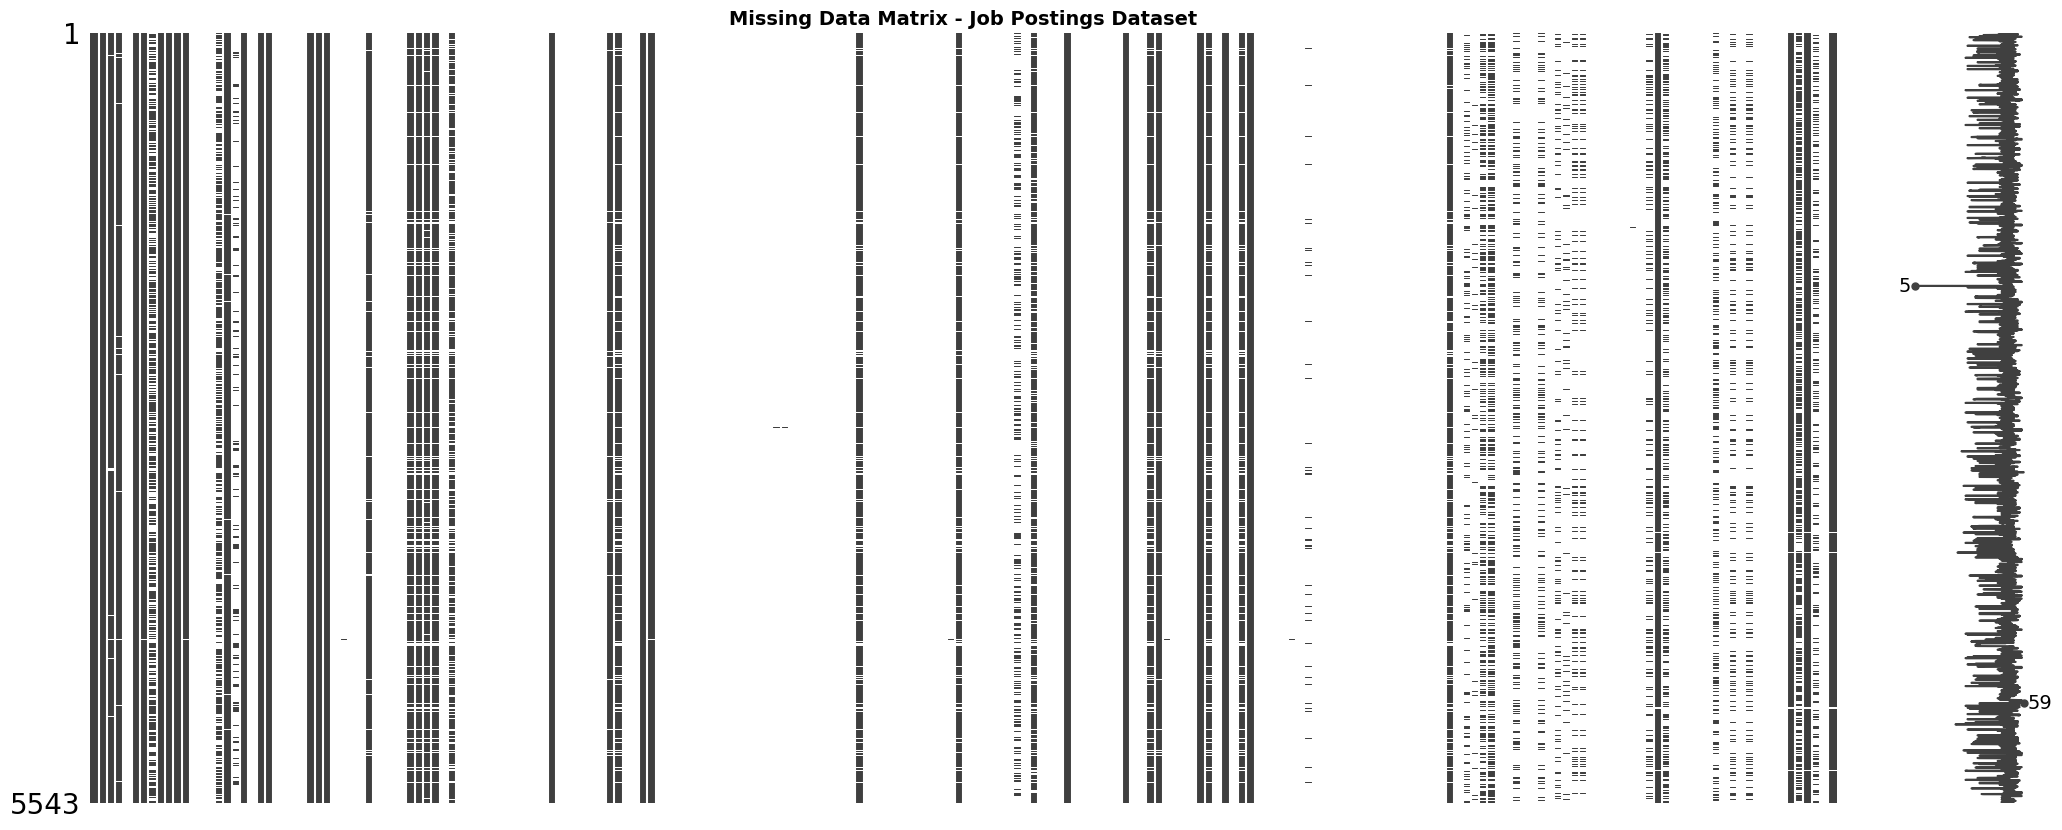

In [ ]:
# Missing data visualization
plt.figure(figsize=(15, 8))
msno.matrix(brca_df)
plt.title("Missing Data Matrix - Breast Cancer Dataset", fontsize=14, fontweight='bold')
plt.show()

In [50]:
# Drop columns with more than 30% missing values except for demographic.days_to_death and diagnoses.days_to_last_follow_up

# Calculate missing percentage for each column
missing_percentages = brca_df.isnull().mean()

# Identify columns to drop (more than 30% missing, excluding the exceptions)
exceptions = ['demographic.days_to_death', 'diagnoses.days_to_last_follow_up']
columns_to_drop = []

for col in brca_df.columns:
    if col not in exceptions and missing_percentages[col] > 0.3:
        columns_to_drop.append(col)

print(f"Columns to be dropped due to >30% missing values: {columns_to_drop}")

# Drop the identified columns
brca_df = brca_df.drop(columns=columns_to_drop)

# Display the shape of the cleaned dataset
brca_df.shape

Columns to be dropped due to >30% missing values: ['cases.days_to_lost_to_followup', 'cases.lost_to_followup', 'demographic.cause_of_death', 'demographic.cause_of_death_source', 'demographic.country_of_birth', 'demographic.country_of_residence_at_enrollment', 'demographic.education_level', 'demographic.marital_status', 'demographic.occupation_duration_years', 'demographic.population_group', 'demographic.premature_at_birth', 'demographic.weeks_gestation_at_birth', 'demographic.year_of_birth', 'demographic.year_of_death', 'diagnoses.adrenal_hormone', 'diagnoses.ajcc_clinical_m', 'diagnoses.ajcc_clinical_n', 'diagnoses.ajcc_clinical_stage', 'diagnoses.ajcc_clinical_t', 'diagnoses.ajcc_serum_tumor_markers', 'diagnoses.ann_arbor_b_symptoms', 'diagnoses.ann_arbor_b_symptoms_described', 'diagnoses.ann_arbor_clinical_stage', 'diagnoses.ann_arbor_extranodal_involvement', 'diagnoses.ann_arbor_pathologic_stage', 'diagnoses.best_overall_response', 'diagnoses.burkitt_lymphoma_clinical_variant', 'di

(5543, 46)

<Figure size 1500x800 with 0 Axes>

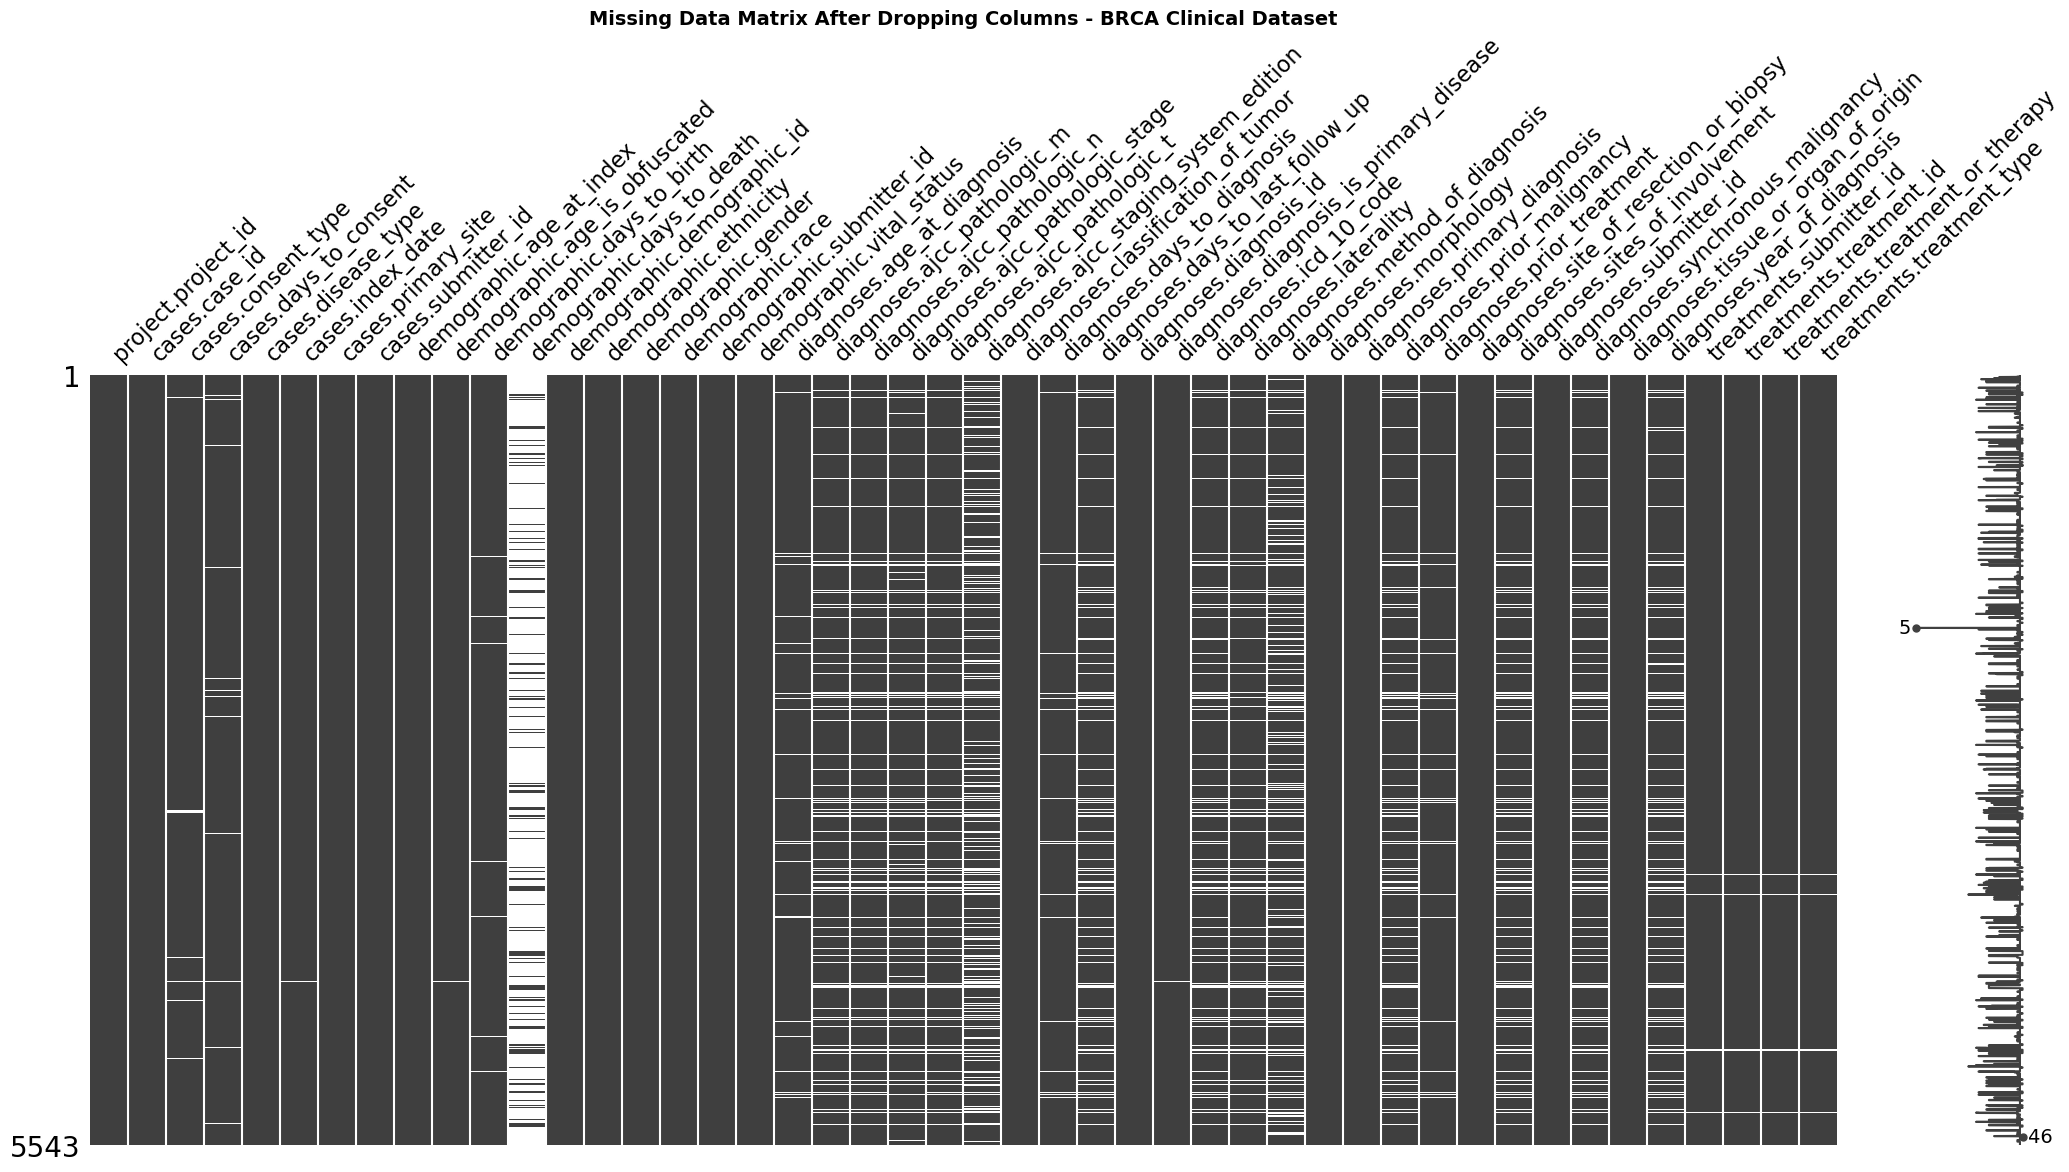

In [51]:
# Check distribution na values after dropping columns
plt.figure(figsize=(15, 8))
msno.matrix(brca_df)
plt.title("Missing Data Matrix After Dropping Columns - BRCA Clinical Dataset", fontsize=14, fontweight='bold')
plt.show()

# Check for duplicate IDs

In [52]:
# Count unique IDs (cases.submitter_id)

unique_ids = brca_df['cases.submitter_id'].nunique()
print(f"Number of unique IDs: {unique_ids}")

Number of unique IDs: 1097


The TGCA BRCA dataset contains 1,082 unique patient IDs (cases.submitter_id) but 3554 rows in total. This is because the TCGA Schema is designed to have multiple samples per patient, capturing different aspects of the tumor biology. Each patient may have multiple entries corresponding to different sample types, such as primary tumor, metastatic tumor, or normal tissue adjacent to the tumor. This allows for a more comprehensive analysis of the cancer's characteristics and progression within the same individual.

The tcga schema is hierarchical as follows:

Case (BRCA) -> Diagnosis -> Follow-up -> Treatment -> Biospecimens

Most BRCA patients have:
- 1 diagnosis
- 1 - 5 follow-up entries
- 1 - 3 treatments
- 2 - 4 tissue samples (tumor and normal)

In [53]:
# Drop completely duplicate rows
brca_df = brca_df.drop_duplicates()

# Filter columns based on task

Columns that are not relevant to the predictive modeling task will be dropped. These include identifiers, dates, and other metadata that do not contribute to the prediction of breast cancer outcomes such as the following:

- cases.consent_type
- cases.days_to_consent
- demographic.days_to_birth
- demographic.age_at_index (will preserve diagnosis.age_at_diagnosis instead for age at diagnosis)
- diagnoses.ajcc_staging_system_edition
- diagnoses.diagnosis_id (captured in disease_type)
- diagnoses.icd_10_code (captured in disease_type)
- diagnoses.year_of_diagnosis (interested in age at diagnosis instead)
- treatments.treatment_id

In [54]:
# Drop irrelevant columns
columns_to_drop = [
    'cases.consent_type',
    'cases.days_to_consent',
    'demographic.days_to_birth',
    'demographic.age_at_index',
    'demographic.demographic_id',
    'diagnoses.ajcc_staging_system_edition',
    'diagnoses.diagnosis_id',
    'diagnoses.icd_10_code',
    'diagnoses.year_of_diagnosis',
    'treatments.treatment_id'
]

# Drop the existing columns
brca_df = brca_df.drop(columns=columns_to_drop)

print(f"Dataset shape after dropping columns: {brca_df.shape}")

Dataset shape after dropping columns: (5543, 36)


<Figure size 1500x800 with 0 Axes>

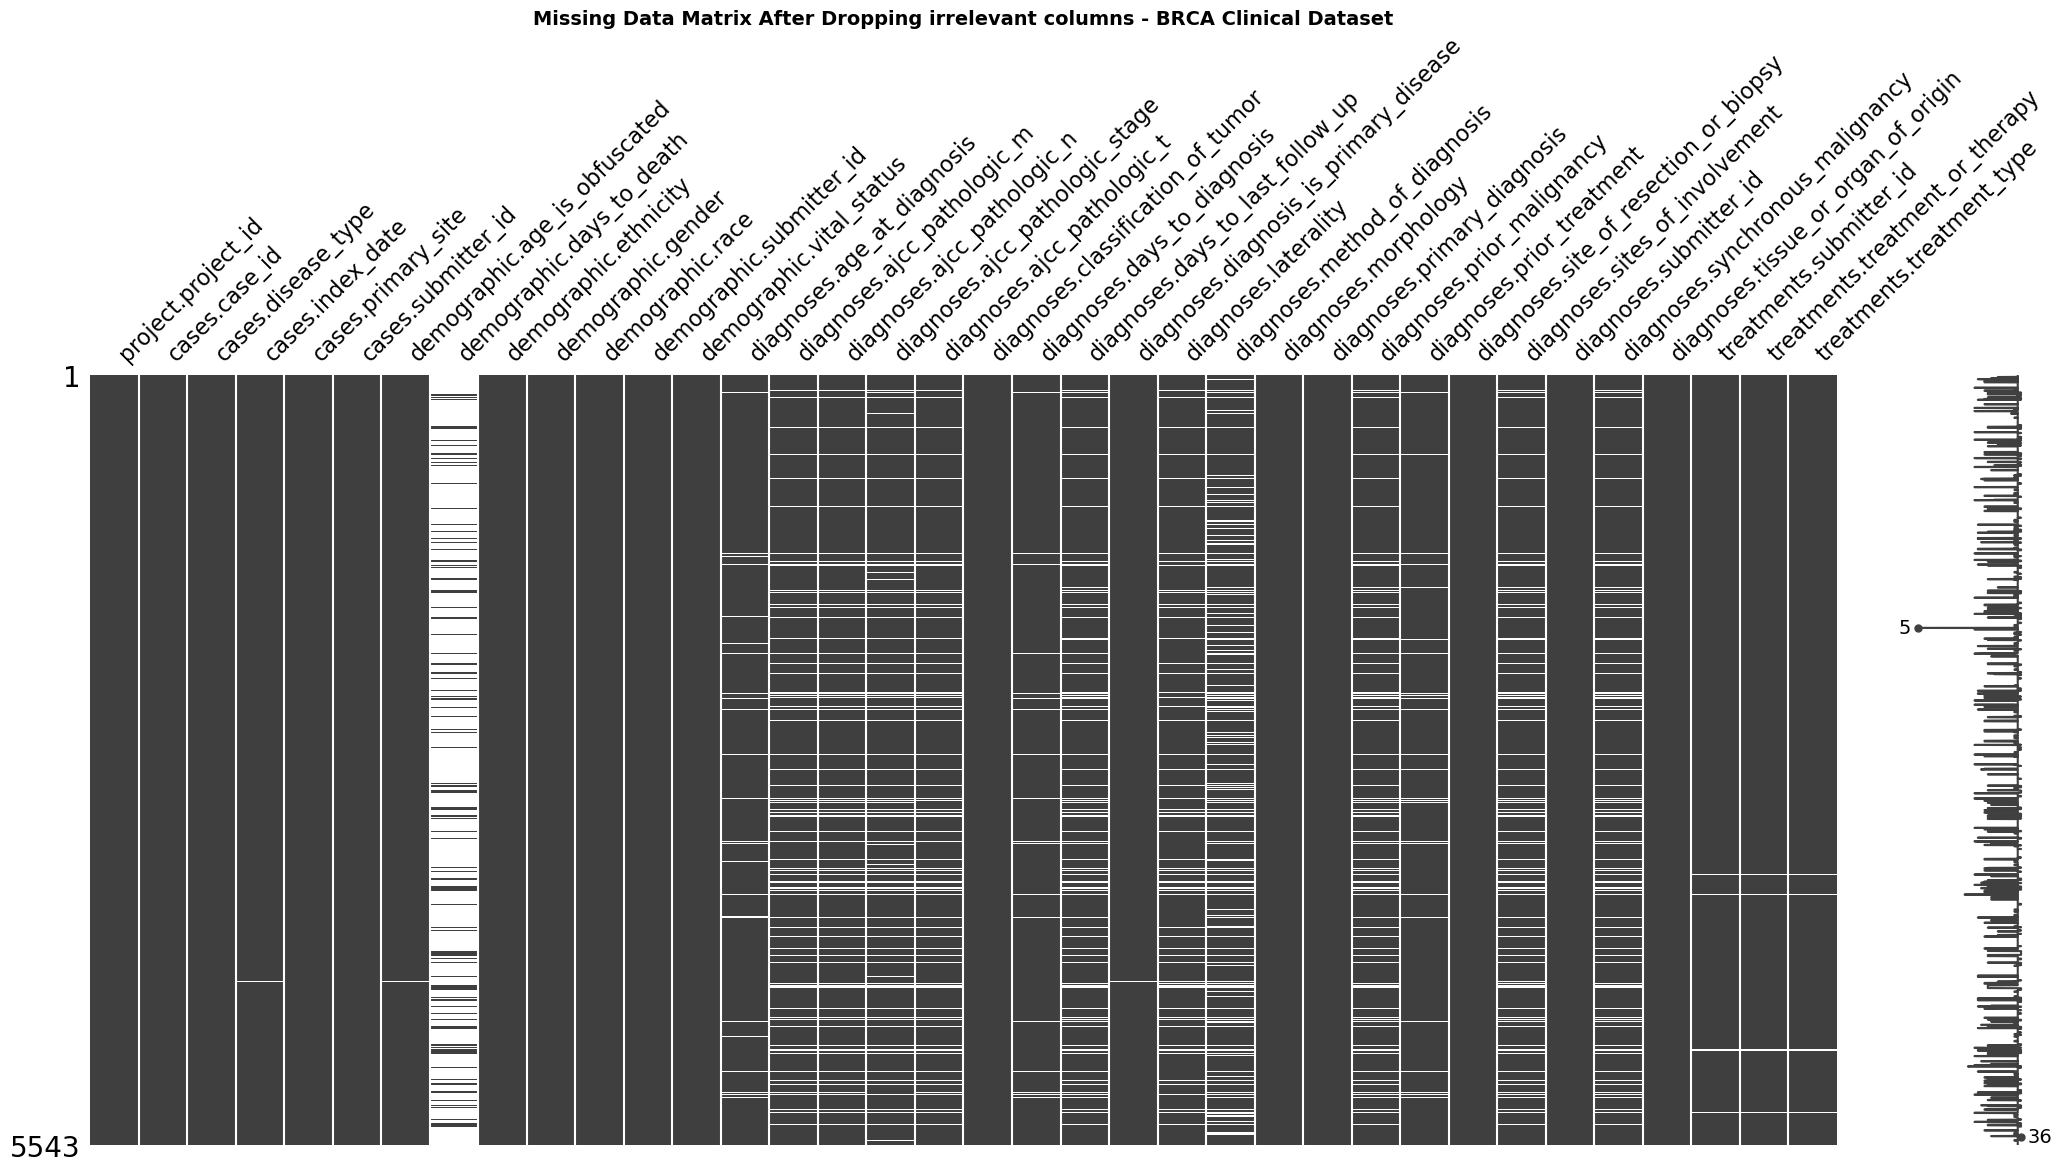

In [55]:
# Using msno to visualize missing data in remaining columns
plt.figure(figsize=(15, 8))
msno.matrix(brca_df)
plt.title("Missing Data Matrix After Dropping irrelevant columns - BRCA Clinical Dataset", fontsize=14, fontweight='bold')
plt.show()

In [56]:
# Check missing value percentages again

for col in brca_df.columns:
    missing_percentage = brca_df[col].isnull().mean() * 100
    print(f"{col}: {missing_percentage:.2f}% missing values")

project.project_id: 0.00% missing values
cases.case_id: 0.00% missing values
cases.disease_type: 0.00% missing values
cases.index_date: 0.05% missing values
cases.primary_site: 0.00% missing values
cases.submitter_id: 0.00% missing values
demographic.age_is_obfuscated: 0.05% missing values
demographic.days_to_death: 84.76% missing values
demographic.ethnicity: 0.02% missing values
demographic.gender: 0.02% missing values
demographic.race: 0.02% missing values
demographic.submitter_id: 0.02% missing values
demographic.vital_status: 0.02% missing values
diagnoses.age_at_diagnosis: 3.50% missing values
diagnoses.ajcc_pathologic_m: 9.44% missing values
diagnoses.ajcc_pathologic_n: 9.44% missing values
diagnoses.ajcc_pathologic_stage: 10.25% missing values
diagnoses.ajcc_pathologic_t: 9.40% missing values
diagnoses.classification_of_tumor: 0.02% missing values
diagnoses.days_to_diagnosis: 2.62% missing values
diagnoses.days_to_last_follow_up: 10.79% missing values
diagnoses.diagnosis_is_pri

In [57]:
# Check distribution of rows that have a lot of missing values
brca_df["na_count"] = brca_df.isna().sum(axis=1)
na_count_distribution = brca_df['na_count'].value_counts().sort_index()
print("\nDistribution of rows by number of missing values:")
print(na_count_distribution)


Distribution of rows by number of missing values:
na_count
0      543
1     3981
2      415
3        4
7       20
8       15
9       37
10     218
11     172
12      27
13      51
14      56
15       1
16       1
17       1
31       1
Name: count, dtype: int64


In [58]:
# Delete rows that have 9 or more missing values (representing over 30% of that entity info missing)
brca_df = brca_df[brca_df['na_count'] < 9].drop(columns=['na_count'])

In [59]:
# Delete rows that have missing age_at_diagnosis info since this is a critical variable for our analysis
brca_df = brca_df[brca_df['diagnoses.age_at_diagnosis'].notna()]

In [60]:
# Check missing value percentages again

for col in brca_df.columns:
    missing_percentage = brca_df[col].isnull().mean() * 100
    print(f"{col}: {missing_percentage:.2f}% missing values")

project.project_id: 0.00% missing values
cases.case_id: 0.00% missing values
cases.disease_type: 0.00% missing values
cases.index_date: 0.04% missing values
cases.primary_site: 0.00% missing values
cases.submitter_id: 0.00% missing values
demographic.age_is_obfuscated: 0.04% missing values
demographic.days_to_death: 88.11% missing values
demographic.ethnicity: 0.00% missing values
demographic.gender: 0.00% missing values
demographic.race: 0.00% missing values
demographic.submitter_id: 0.00% missing values
demographic.vital_status: 0.00% missing values
diagnoses.age_at_diagnosis: 0.00% missing values
diagnoses.ajcc_pathologic_m: 0.00% missing values
diagnoses.ajcc_pathologic_n: 0.00% missing values
diagnoses.ajcc_pathologic_stage: 0.89% missing values
diagnoses.ajcc_pathologic_t: 0.06% missing values
diagnoses.classification_of_tumor: 0.00% missing values
diagnoses.days_to_diagnosis: 0.00% missing values
diagnoses.days_to_last_follow_up: 0.49% missing values
diagnoses.diagnosis_is_prima

<Figure size 1500x800 with 0 Axes>

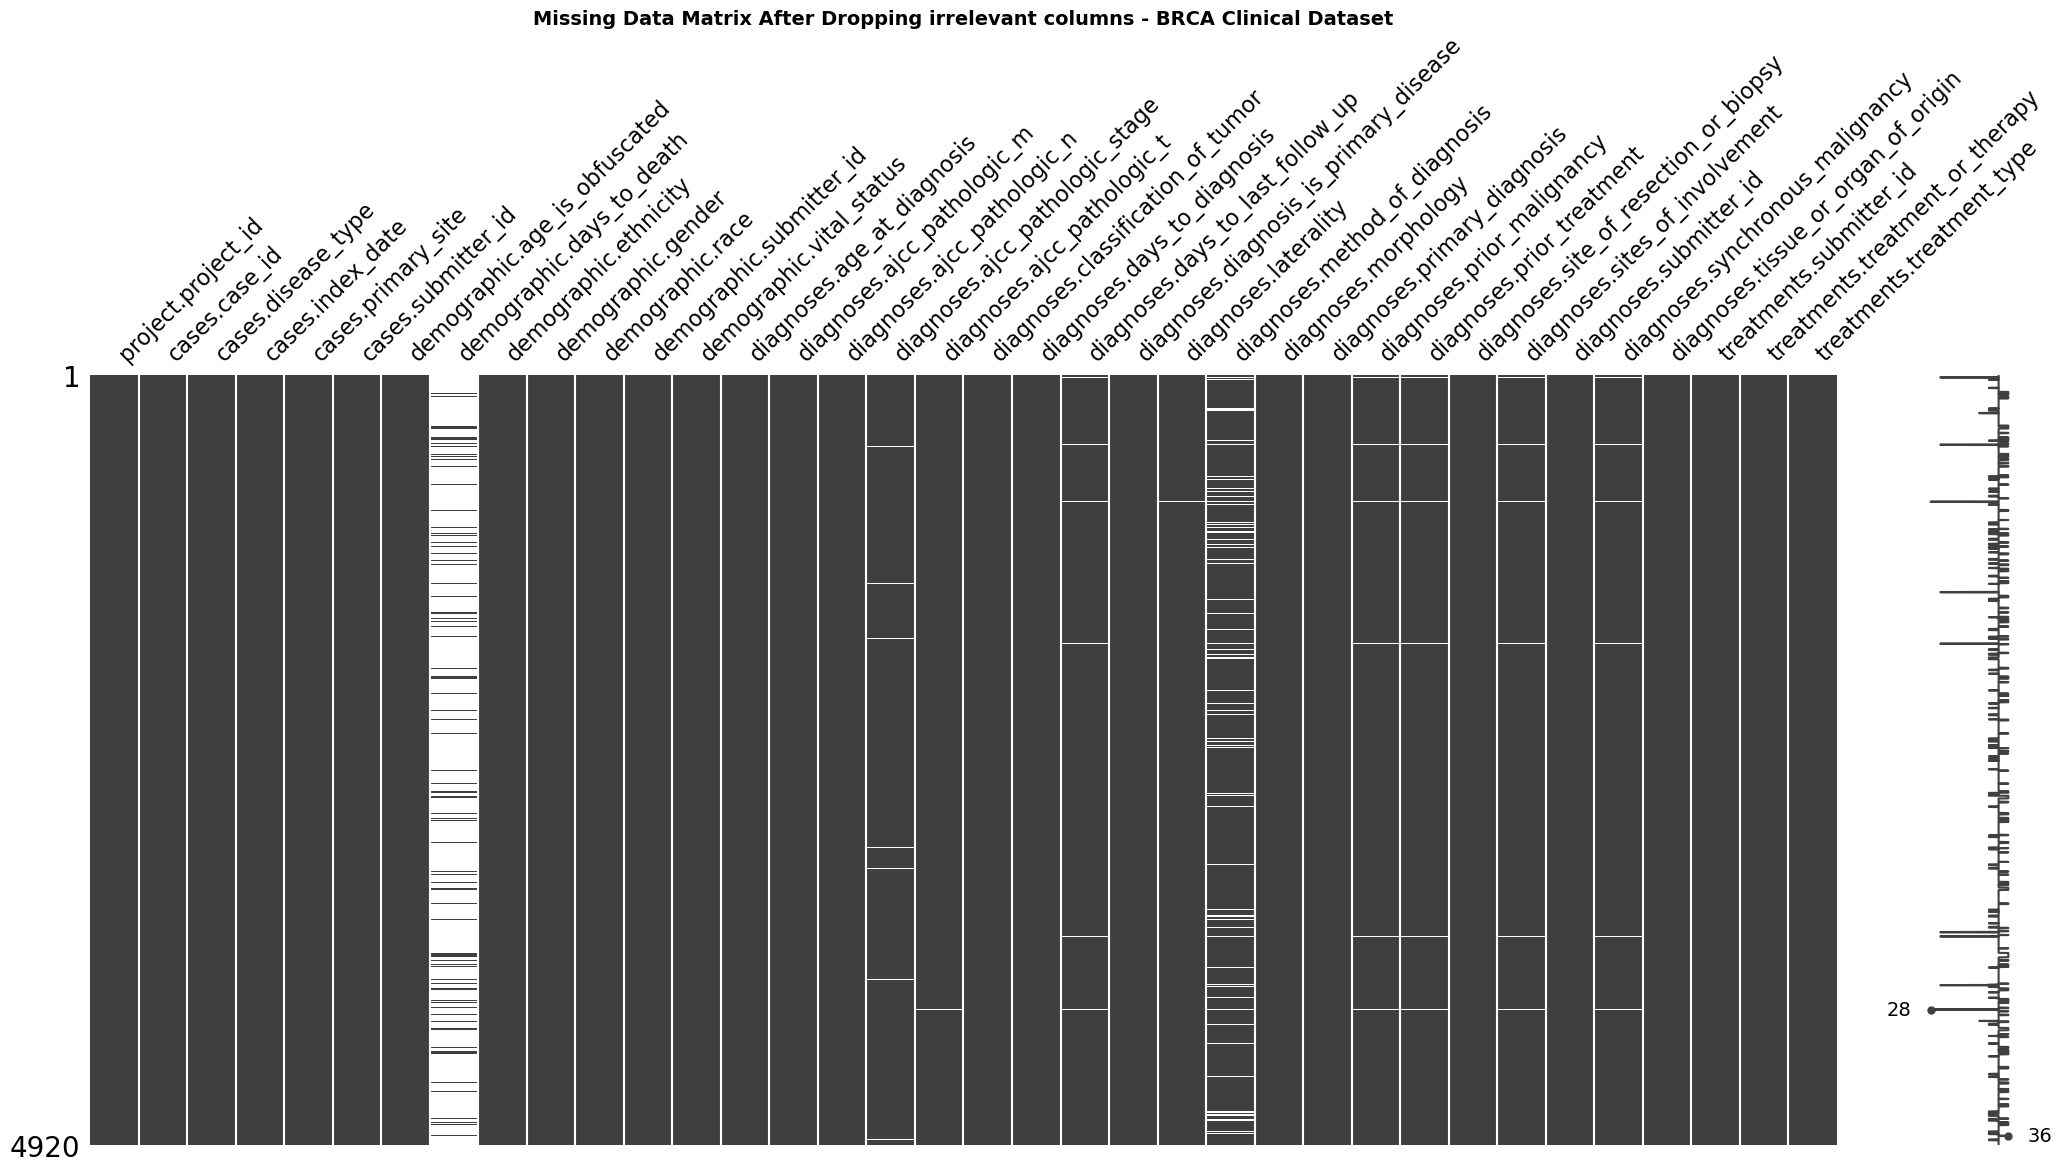

In [61]:
# Using msno to visualize missing data in remaining columns
plt.figure(figsize=(15, 8))
msno.matrix(brca_df)
plt.title("Missing Data Matrix After Dropping irrelevant columns - BRCA Clinical Dataset", fontsize=14, fontweight='bold')
plt.show()

In [62]:
# Check the distribution of the method_of_diagnosis since it has a significantly higher missing value percentage
method_of_diagnosis_counts = brca_df['diagnoses.method_of_diagnosis'].value_counts(dropna=False)
print("\ndiagnoses.method_of_diagnosis distribution:")
print(method_of_diagnosis_counts)


diagnoses.method_of_diagnosis distribution:
diagnoses.method_of_diagnosis
Core Biopsy                 2932
Surgical Resection           797
NaN                          398
Fine Needle Aspiration       380
Excisional Biopsy            143
Cytology                     124
Biopsy                        67
Incisional Biopsy             66
Ultrasound Guided Biopsy       7
Unknown                        6
Name: count, dtype: int64


Due to the heavy imbalance leaning towards Core Biopsy for the diagnoses.method_of_diagnosis column, we can replace missing values with 'Core Biopsy' to retain more rows for analysis.

In [63]:
# Distribution of cases.index_date
index_date_counts = brca_df['cases.index_date'].value_counts(dropna=False)
print("\ncases.index_date distribution:")
print(index_date_counts)


cases.index_date distribution:
cases.index_date
Diagnosis    4918
NaN             2
Name: count, dtype: int64


Due to the heavy imbalance leaning towards Diagnosis for the cases.index_date column, we can replace missing values with 'Diagnosis' to retain more rows for analysis.

In [64]:
# Set pandas options to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [65]:
# Check rows that have missing age_is_obfuscated 
brca_df[brca_df['demographic.age_is_obfuscated'].isna()].head()

,project.project_id,cases.case_id,cases.disease_type,cases.index_date,cases.primary_site,cases.submitter_id,demographic.age_is_obfuscated,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.submitter_id,demographic.vital_status,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_stage,diagnoses.ajcc_pathologic_t,diagnoses.classification_of_tumor,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.diagnosis_is_primary_disease,diagnoses.laterality,diagnoses.method_of_diagnosis,diagnoses.morphology,diagnoses.primary_diagnosis,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.site_of_resection_or_biopsy,diagnoses.sites_of_involvement,diagnoses.submitter_id,diagnoses.synchronous_malignancy,diagnoses.tissue_or_organ_of_origin,treatments.submitter_id,treatments.treatment_or_therapy,treatments.treatment_type
4368,TCGA-BRCA,cb9f5e50-f49d-4899-8895-9367afcc1015,Ductal and Lobular Neoplasms,NaN,Breast,TCGA-A7-A0DC,NaN,NaN,not hispanic or latino,female,white,TCGA-A7-A0DC_demographic,Alive,23294,M0,N0 (i-),Stage IA,T1c,not reported,0,906.0,NaN,NaN,NaN,8500/3,"Infiltrating duct carcinoma, NOS",no,No,"Breast, NOS",NaN,TCGA-A7-A0DC_diagnosis,No,"Breast, NOS",TCGA-A7-A0DC_treatment_1,yes,"Pharmaceutical Therapy, NOS"
4369,TCGA-BRCA,cb9f5e50-f49d-4899-8895-9367afcc1015,Ductal and Lobular Neoplasms,NaN,Breast,TCGA-A7-A0DC,NaN,NaN,not hispanic or latino,female,white,TCGA-A7-A0DC_demographic,Alive,23294,M0,N0 (i-),Stage IA,T1c,not reported,0,906.0,NaN,NaN,NaN,8500/3,"Infiltrating duct carcinoma, NOS",no,No,"Breast, NOS",NaN,TCGA-A7-A0DC_diagnosis,No,"Breast, NOS",TCGA-A7-A0DC_treatment,yes,"Radiation Therapy, NOS"


It seems that when age is obfuscated is NaN, age_at_diagnosis exists, therefore we can replace these with False

In [66]:
# Check distribution of diagnoses.ajcc_pathologic_n 
ajcc_pathologic_stage_counts = brca_df['diagnoses.ajcc_pathologic_n'].value_counts(dropna=False)
print("\ndiagnoses.ajcc_pathologic_n distribution:")
print(ajcc_pathologic_stage_counts)


diagnoses.ajcc_pathologic_n distribution:
diagnoses.ajcc_pathologic_n
N0           1289
N1a           839
N0 (i-)       682
N1            579
N2a           352
N2            267
N3a           247
N1mi          178
N0 (i+)       138
N3            130
N1b           104
NX             77
N3b            16
N3c            13
N1c             6
N0 (mol+)       3
Name: count, dtype: int64


In [67]:
# Check distribution of diagnoses.ajcc_pathologic_m 
ajcc_pathologic_stage_counts = brca_df['diagnoses.ajcc_pathologic_m'].value_counts(dropna=False)
print("\ndiagnoses.ajcc_pathologic_m distribution:")
print(ajcc_pathologic_stage_counts)


diagnoses.ajcc_pathologic_m distribution:
diagnoses.ajcc_pathologic_m
M0          4095
MX           703
M1            87
cM0 (i+)      35
Name: count, dtype: int64


In [68]:
# Check distribution of diagnoses.ajcc_pathologic_t 
ajcc_pathologic_stage_counts = brca_df['diagnoses.ajcc_pathologic_t'].value_counts(dropna=False)
print("\ndiagnoses.ajcc_pathologic_t distribution:")
print(ajcc_pathologic_stage_counts)


diagnoses.ajcc_pathologic_t distribution:
diagnoses.ajcc_pathologic_t
T2            2908
T1c            941
T3             649
T1             178
T4b             94
T1b             76
T4              31
T4d             12
TX               9
Tis (DCIS)       6
T3a              4
T2a              4
Tis              3
NaN              3
T1a              1
T2b              1
Name: count, dtype: int64


In [69]:
# Check distribution of diagnoses.ajcc_pathologic_stage 
ajcc_pathologic_stage_counts = brca_df['diagnoses.ajcc_pathologic_stage'].value_counts(dropna=False)
print("\ndiagnoses.ajcc_pathologic_stage distribution:")
print(ajcc_pathologic_stage_counts)


diagnoses.ajcc_pathologic_stage distribution:
diagnoses.ajcc_pathologic_stage
Stage IIA     1532
Stage IIB     1227
Stage IIIA     787
Stage IIIC     364
Stage I        341
Stage IA       338
Stage IIIB      89
Stage IV        77
NaN             44
Stage X         42
Stage IB        33
Stage II        25
Stage III       12
Stage 0          6
Stage 0is        3
Name: count, dtype: int64


The missing values in the diagnoses.ajcc_pathologic_t, diagnoses.ajcc_pathologic_n, and diagnoses.ajcc_pathologic_m columns will be replaced by the mode of each column respectively and the state (diagnoses.ajcc_pathologic_stage) will be derived from these three columns using the AJCC staging guidelines.

In [70]:
# Check rows with missing diagnoses.ajcc_pathologic_stage
brca_df[brca_df['diagnoses.ajcc_pathologic_stage'].isna()].head()

,project.project_id,cases.case_id,cases.disease_type,cases.index_date,cases.primary_site,cases.submitter_id,demographic.age_is_obfuscated,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.submitter_id,demographic.vital_status,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_stage,diagnoses.ajcc_pathologic_t,diagnoses.classification_of_tumor,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.diagnosis_is_primary_disease,diagnoses.laterality,diagnoses.method_of_diagnosis,diagnoses.morphology,diagnoses.primary_diagnosis,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.site_of_resection_or_biopsy,diagnoses.sites_of_involvement,diagnoses.submitter_id,diagnoses.synchronous_malignancy,diagnoses.tissue_or_organ_of_origin,treatments.submitter_id,treatments.treatment_or_therapy,treatments.treatment_type
276,TCGA-BRCA,0adf59c6-581a-475d-a2f4-40aa40060b5b,Ductal and Lobular Neoplasms,Diagnosis,Breast,TCGA-A8-A09T,false,NaN,not reported,female,not reported,TCGA-A8-A09T_demographic,Alive,25110,MX,N0,NaN,T1c,primary,0,579.0,true,Left,NaN,8520/3,"Lobular carcinoma, NOS",no,No,"Breast, NOS","Breast, NOS",TCGA-A8-A09T_diagnosis,No,"Breast, NOS",TCGA-A8-A09T_treatment2,yes,Hormone Therapy
277,TCGA-BRCA,0adf59c6-581a-475d-a2f4-40aa40060b5b,Ductal and Lobular Neoplasms,Diagnosis,Breast,TCGA-A8-A09T,false,NaN,not reported,female,not reported,TCGA-A8-A09T_demographic,Alive,25110,MX,N0,NaN,T1c,primary,0,579.0,true,Left,NaN,8520/3,"Lobular carcinoma, NOS",no,No,"Breast, NOS","Breast, NOS",TCGA-A8-A09T_diagnosis,No,"Breast, NOS",TCGA-A8-A09T_treatment3,yes,"Surgery, NOS"
278,TCGA-BRCA,0adf59c6-581a-475d-a2f4-40aa40060b5b,Ductal and Lobular Neoplasms,Diagnosis,Breast,TCGA-A8-A09T,false,NaN,not reported,female,not reported,TCGA-A8-A09T_demographic,Alive,25110,MX,N0,NaN,T1c,primary,0,579.0,true,Left,NaN,8520/3,"Lobular carcinoma, NOS",no,No,"Breast, NOS","Breast, NOS",TCGA-A8-A09T_diagnosis,No,"Breast, NOS",TCGA-A8-A09T_treatment,yes,"Radiation, External Beam"
508,TCGA-BRCA,178b2c48-c07d-422e-ae17-8bcfd996ad51,Ductal and Lobular Neoplasms,Diagnosis,Breast,TCGA-B6-A0X1,false,7455,not hispanic or latino,female,white,TCGA-B6-A0X1_demographic,Dead,17624,M1,N1,NaN,T2,primary,0,7455.0,true,Left,Fine Needle Aspiration,8500/3,"Infiltrating duct carcinoma, NOS",no,No,"Breast, NOS","Breast, NOS",TCGA-B6-A0X1_diagnosis,No,"Breast, NOS",TCGA-B6-A0X1_treatment3,yes,"Surgery, NOS"
509,TCGA-BRCA,178b2c48-c07d-422e-ae17-8bcfd996ad51,Ductal and Lobular Neoplasms,Diagnosis,Breast,TCGA-B6-A0X1,false,7455,not hispanic or latino,female,white,TCGA-B6-A0X1_demographic,Dead,17624,M1,N1,NaN,T2,primary,0,7455.0,true,Left,Fine Needle Aspiration,8500/3,"Infiltrating duct carcinoma, NOS",no,No,"Breast, NOS","Breast, NOS",TCGA-B6-A0X1_diagnosis,No,"Breast, NOS",TCGA-B6-A0X1_treatment,yes,"Pharmaceutical Therapy, NOS"


In [71]:
# Percentage of missing values in each column
missing_percentages = brca_df.isnull().mean() * 100
print("\nPercentage of missing values in each column:")
print(missing_percentages)


Percentage of missing values in each column:
project.project_id                         0.000000
cases.case_id                              0.000000
cases.disease_type                         0.000000
cases.index_date                           0.040650
cases.primary_site                         0.000000
cases.submitter_id                         0.000000
demographic.age_is_obfuscated              0.040650
demographic.days_to_death                 88.109756
demographic.ethnicity                      0.000000
demographic.gender                         0.000000
demographic.race                           0.000000
demographic.submitter_id                   0.000000
demographic.vital_status                   0.000000
diagnoses.age_at_diagnosis                 0.000000
diagnoses.ajcc_pathologic_m                0.000000
diagnoses.ajcc_pathologic_n                0.000000
diagnoses.ajcc_pathologic_stage            0.894309
diagnoses.ajcc_pathologic_t                0.060976
diagnoses.classifi

In [72]:
# Check distribution of diagnoses.treatment_or_therapy
treatment_or_therapy_counts = brca_df['treatments.treatment_or_therapy'].value_counts(dropna=False)
print("\ntreatments.treatment_or_therapy distribution:")
print(treatment_or_therapy_counts)


treatments.treatment_or_therapy distribution:
treatments.treatment_or_therapy
yes        4289
no          559
unknown      72
Name: count, dtype: int64


# Clean NA values 

Replace the missing values in the following columns based on the assigned strategy:
- cases.index_date: 'Diagnosis' (most frequent)
- diagnoses.method_of_diagnosis: 'Core Biopsy' (most frequent)
- demographic.age_is_obfuscated: 'False' (age is still present despite na)
- diagnoses.ajcc_pathologic_n: 'N0' (most frequent)
- diagnoses.ajcc_pathologic_m: 'M0' (most frequent)
- diagnoses.ajcc_pathologic_t: 'T2' (most frequent)
- diagnoses.ajcc_pathologic_stage: infered from other ajcc_pathologic columns according to the following mapping:
    - T1, N0, M0 -> Stage I
    - T2, N0, M0 -> Stage II
    - T3, N0, M0 -> Stage III
    - T4, N0, M0 -> Stage IV
    - T1, N1, M0 -> Stage II
    - T2, N1, M0 -> Stage III
    - T3, N1, M0 -> Stage III
    - T4, N1, M0 -> Stage IV
- diagnoses.diagnosis_is_primary_disease: 'True' (most frequent)
- diagnoses.laterality : 'Left' (most frequent)
- diagnoses.prior_malignancy: 'False' (most frequent)
- diagnoses.prior_treatment: 'False' (most frequent)
- diagnoses.sites_of_involvement: 'Breast' (most frequent)
- diagnoses.synchronous_malignancy: 'False' (most frequent)
- diagnoses.treatment_or_therapy: True (most frequent)

In [73]:
# Replace missing values based on the strategy above:

# Replace with most frequent values
brca_df['cases.index_date'] = brca_df['cases.index_date'].fillna('diagnosis')
brca_df['diagnoses.method_of_diagnosis'] = brca_df['diagnoses.method_of_diagnosis'].fillna('core biopsy')
brca_df['demographic.age_is_obfuscated'] = brca_df['demographic.age_is_obfuscated'].fillna('false')
brca_df['diagnoses.ajcc_pathologic_n'] = brca_df['diagnoses.ajcc_pathologic_n'].fillna('n0')
brca_df['diagnoses.ajcc_pathologic_m'] = brca_df['diagnoses.ajcc_pathologic_m'].fillna('m0')
brca_df['diagnoses.ajcc_pathologic_t'] = brca_df['diagnoses.ajcc_pathologic_t'].fillna('t2')
brca_df['diagnoses.diagnosis_is_primary_disease'] = brca_df['diagnoses.diagnosis_is_primary_disease'].fillna('true')
brca_df['diagnoses.laterality'] = brca_df['diagnoses.laterality'].fillna('left')
brca_df['diagnoses.prior_malignancy'] = brca_df['diagnoses.prior_malignancy'].fillna('no')
brca_df['diagnoses.prior_treatment'] = brca_df['diagnoses.prior_treatment'].fillna('no')
brca_df['diagnoses.sites_of_involvement'] = brca_df['diagnoses.sites_of_involvement'].fillna('breast')
brca_df['diagnoses.synchronous_malignancy'] = brca_df['diagnoses.synchronous_malignancy'].fillna('no')
brca_df['treatments.treatment_or_therapy'] = brca_df['treatments.treatment_or_therapy'].fillna('True')

# Define AJCC staging mapping
def get_ajcc_stage(t, n, m):
    """Map T, N, M values to AJCC stage"""
    # Extract numeric/classification parts (remove 'T', 'N', 'M' prefixes)
    t_val = t.lower().replace('t', '') if pd.notna(t) else '2'
    n_val = n.lower().replace('n', '') if pd.notna(n) else '0'
    m_val = m.lower().replace('m', '') if pd.notna(m) else '0'
    
    # Stage mapping logic
    if m_val != '0':
        return 'stage iv'  # Any distant metastasis is Stage IV
    elif t_val == '1' and n_val == '0':
        return 'stage i'
    elif (t_val == '2' and n_val == '0') or (t_val == '1' and n_val == '1'):
        return 'stage ii'
    elif (t_val == '3' and n_val == '0') or (t_val == '2' and n_val == '1') or (t_val == '3' and n_val == '1'):
        return 'stage iii'
    elif t_val == '4':
        return 'stage iv'
    else:
        return 'stage ii'  # Default fallback

# Apply staging logic to fill missing values
for idx, row in brca_df.iterrows():
    if pd.isna(row['diagnoses.ajcc_pathologic_stage']):
        stage = get_ajcc_stage(
            row['diagnoses.ajcc_pathologic_t'],
            row['diagnoses.ajcc_pathologic_n'], 
            row['diagnoses.ajcc_pathologic_m']
        )
        brca_df.at[idx, 'diagnoses.ajcc_pathologic_stage'] = stage

In [74]:
# Check missing values after replacement
print("Missing values after replacement:")
for col in brca_df.columns:
    missing_count = brca_df[col].isnull().sum()
    if missing_count > 0:
        print(f"{col}: {missing_count} missing values")

print(f"\nTotal missing values across all columns: {brca_df.isnull().sum().sum()}")

Missing values after replacement:
demographic.days_to_death: 4335 missing values
diagnoses.days_to_last_follow_up: 24 missing values

Total missing values across all columns: 4359


# Check for consistent data types

In [75]:
# Check column data types

brca_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4920 entries, 0 to 5545
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   project.project_id                      4920 non-null   object
 1   cases.case_id                           4920 non-null   object
 2   cases.disease_type                      4920 non-null   object
 3   cases.index_date                        4920 non-null   object
 4   cases.primary_site                      4920 non-null   object
 5   cases.submitter_id                      4920 non-null   object
 6   demographic.age_is_obfuscated           4920 non-null   object
 7   demographic.days_to_death               585 non-null    object
 8   demographic.ethnicity                   4920 non-null   object
 9   demographic.gender                      4920 non-null   object
 10  demographic.race                        4920 non-null   object
 11  demograph

In [76]:
# Check the statistical summary of diagnoses.age_at_diagnosis

# Convert to numeric 
brca_df['diagnoses.age_at_diagnosis'] = pd.to_numeric(brca_df['diagnoses.age_at_diagnosis'], errors='coerce')

# Statistical summary
print("Statistical Summary of Age at Diagnosis:")
print(brca_df['diagnoses.age_at_diagnosis'].describe())

print(f"\nMean: {brca_df['diagnoses.age_at_diagnosis'].mean():.2f}")
print(f"Median: {brca_df['diagnoses.age_at_diagnosis'].median():.2f}")
print(f"Standard Deviation: {brca_df['diagnoses.age_at_diagnosis'].std():.2f}")
print(f"Missing values: {brca_df['diagnoses.age_at_diagnosis'].isna().sum()}")

Statistical Summary of Age at Diagnosis:
count     4920.000000
mean     20899.613618
std       4578.709865
min       9706.000000
25%      17561.500000
50%      20708.500000
75%      23699.750000
max      32872.000000
Name: diagnoses.age_at_diagnosis, dtype: float64

Mean: 20899.61
Median: 20708.50
Standard Deviation: 4578.71
Missing values: 0


The age at diagnosis column has been converted to numeric but the values are in days. For analysis we will convert these to years by dividing by 365.25 (accounting for leap years) and rounding down

In [77]:
# Convert age at diagnosis from days to years (integer)
brca_df['diagnoses.age_at_diagnosis'] = (brca_df['diagnoses.age_at_diagnosis'] / 365.25).apply(np.floor)

In [78]:
# Check the statistical summary of diagnoses.age_at_diagnosis

# Convert to numeric 
brca_df['diagnoses.age_at_diagnosis'] = pd.to_numeric(brca_df['diagnoses.age_at_diagnosis'], errors='coerce')

# Statistical summary
print("Statistical Summary of Age at Diagnosis:")
print(brca_df['diagnoses.age_at_diagnosis'].describe())

print(f"\nMean: {brca_df['diagnoses.age_at_diagnosis'].mean():.2f}")
print(f"Median: {brca_df['diagnoses.age_at_diagnosis'].median():.2f}")
print(f"Standard Deviation: {brca_df['diagnoses.age_at_diagnosis'].std():.2f}")
print(f"Missing values: {brca_df['diagnoses.age_at_diagnosis'].isna().sum()}")

Statistical Summary of Age at Diagnosis:
count    4920.000000
mean       56.710569
std        12.529500
min        26.000000
25%        48.000000
50%        56.000000
75%        64.000000
max        89.000000
Name: diagnoses.age_at_diagnosis, dtype: float64

Mean: 56.71
Median: 56.00
Standard Deviation: 12.53
Missing values: 0


In [79]:
# Convert to integer
brca_df['diagnoses.age_at_diagnosis'] = pd.to_numeric(
    brca_df['diagnoses.age_at_diagnosis'], 
    errors='coerce'
)
brca_df['diagnoses.age_at_diagnosis'].dtype

dtype('float64')

In [80]:
# Change all object type columns to lowercase
for col in brca_df.select_dtypes(include=['object']).columns:
    brca_df[col] = brca_df[col].astype(str).str.lower().replace('nan', np.nan)

In [81]:
# strip whitespace from string columns
for col in brca_df.select_dtypes(include=['object']).columns:
    brca_df[col] = brca_df[col].str.strip()

In [82]:
# Change demographic.age_is_obfuscated to boolean
brca_df['demographic.age_is_obfuscated'] = brca_df['demographic.age_is_obfuscated'].map({'false': False, 'true': True})

# Check the conversion
print(brca_df['demographic.age_is_obfuscated'].value_counts())


demographic.age_is_obfuscated
False    4862
True       58
Name: count, dtype: int64


In [83]:
# Convert treatments.treatment_or_therapy to boolean from yes/no
brca_df['treatments.treatment_or_therapy'] = brca_df['treatments.treatment_or_therapy'].map({'yes': True, 'no': False}) 
# Check the conversion
print(brca_df['treatments.treatment_or_therapy'].value_counts())

treatments.treatment_or_therapy
True     4289
False     559
Name: count, dtype: int64


Change other columns to boolean as appropriate:
- diagnoses.diagnosis_is_primary_disease (from true/false strings)
- diagnoses.prior_malignancy (from no/yes strings)
- diagnoses.prior_treatment (from No/Yes strings)
- diagnoses.synchronous_malignancy (from no/yes strings)

In [84]:
# Convert diagnosis-related columns to boolean

# Convert diagnoses.diagnosis_is_primary_disease (true/false to boolean)
brca_df['diagnoses.diagnosis_is_primary_disease'] = brca_df['diagnoses.diagnosis_is_primary_disease'].map({'true': True, 'false': False})

# Convert diagnoses.prior_malignancy (yes/no to boolean)
brca_df['diagnoses.prior_malignancy'] = brca_df['diagnoses.prior_malignancy'].map({'yes': True, 'no': False})

# Convert diagnoses.prior_treatment (yes/no to boolean)
brca_df['diagnoses.prior_treatment'] = brca_df['diagnoses.prior_treatment'].map({'yes': True, 'no': False})

# Convert diagnoses.synchronous_malignancy (yes/no to boolean)
brca_df['diagnoses.synchronous_malignancy'] = brca_df['diagnoses.synchronous_malignancy'].map({'yes': True, 'no': False})

# Check the conversions
print("Conversion results:")
print(f"diagnoses.diagnosis_is_primary_disease dtype: {brca_df['diagnoses.diagnosis_is_primary_disease'].dtype}")
print(f"diagnoses.prior_malignancy dtype: {brca_df['diagnoses.prior_malignancy'].dtype}")
print(f"diagnoses.prior_treatment dtype: {brca_df['diagnoses.prior_treatment'].dtype}")
print(f"diagnoses.synchronous_malignancy dtype: {brca_df['diagnoses.synchronous_malignancy'].dtype}")

print("\nValue counts for each column:")
for col in ['diagnoses.diagnosis_is_primary_disease', 'diagnoses.prior_malignancy', 
           'diagnoses.prior_treatment', 'diagnoses.synchronous_malignancy']:
    print(f"\n{col}:")
    print(brca_df[col].value_counts())

Conversion results:
diagnoses.diagnosis_is_primary_disease dtype: bool
diagnoses.prior_malignancy dtype: object
diagnoses.prior_treatment dtype: object
diagnoses.synchronous_malignancy dtype: object

Value counts for each column:

diagnoses.diagnosis_is_primary_disease:
diagnoses.diagnosis_is_primary_disease
True     4896
False      24
Name: count, dtype: int64

diagnoses.prior_malignancy:
diagnoses.prior_malignancy
False    4738
True      133
Name: count, dtype: int64

diagnoses.prior_treatment:
diagnoses.prior_treatment
False    4862
True       48
Name: count, dtype: int64

diagnoses.synchronous_malignancy:
diagnoses.synchronous_malignancy
False    4763
True      108
Name: count, dtype: int64


# Data Engineering

In [85]:
# Percentage of missing values in each column
missing_percentages = brca_df.isnull().mean() * 100
print("\nPercentage of missing values in each column:")
print(missing_percentages)


Percentage of missing values in each column:
project.project_id                         0.000000
cases.case_id                              0.000000
cases.disease_type                         0.000000
cases.index_date                           0.000000
cases.primary_site                         0.000000
cases.submitter_id                         0.000000
demographic.age_is_obfuscated              0.000000
demographic.days_to_death                 88.109756
demographic.ethnicity                      0.000000
demographic.gender                         0.000000
demographic.race                           0.000000
demographic.submitter_id                   0.000000
demographic.vital_status                   0.000000
diagnoses.age_at_diagnosis                 0.000000
diagnoses.ajcc_pathologic_m                0.000000
diagnoses.ajcc_pathologic_n                0.000000
diagnoses.ajcc_pathologic_stage            0.000000
diagnoses.ajcc_pathologic_t                0.000000
diagnoses.classifi

In [86]:
# Check percentage of missing values in days_to_death when vital_status is 'dead'
missing_death_percentage = brca_df[brca_df['demographic.vital_status'] == 'dead']['demographic.days_to_death'].isnull().mean()
print(f"Percentage of missing values in 'demographic.days_to_death' when vital_status is 'dead': {missing_death_percentage:.2%}")    

Percentage of missing values in 'demographic.days_to_death' when vital_status is 'dead': 0.00%


In [87]:
# Percentage of missing values in days_to_last_follow_up when vital_status is 'alive'
missing_followup_percentage = brca_df[brca_df['demographic.vital_status'] == 'alive']['diagnoses.days_to_last_follow_up'].isnull().mean()
print(f"Percentage of missing values in 'diagnoses.days_to_last_follow_up' when vital_status is 'alive': {missing_followup_percentage:.2%}")

Percentage of missing values in 'diagnoses.days_to_last_follow_up' when vital_status is 'alive': 0.55%


In [88]:
# Change days_to_last_follow_up to numeric
brca_df['diagnoses.days_to_last_follow_up'] = pd.to_numeric(
    brca_df['diagnoses.days_to_last_follow_up'], 
    errors='coerce'
)

In [89]:
# Check distribution of days_to_last_follow_up
brca_df['diagnoses.days_to_last_follow_up'].describe()

count    4896.000000
mean     1323.354575
std      1176.067445
min        -7.000000
25%       525.000000
50%       972.000000
75%      1876.000000
max      8605.000000
Name: diagnoses.days_to_last_follow_up, dtype: float64

In [ ]:
# Replace days to last follow up values less than 0 to with mean
brca_df.loc[brca_df['diagnoses.days_to_last_follow_up'] < 0, 'diagnoses.days_to_last_follow_up'] = np.nan
mean_followup = brca_df['diagnoses.days_to_last_follow_up'].mean()
brca_df['diagnoses.days_to_last_follow_up'].fillna(mean_followup, inplace=True)

In [91]:
# Create survival time column based on vital status
def calculate_survival_time(row):
    if row['demographic.vital_status'] == 'dead':
        return row['demographic.days_to_death']
    elif row['demographic.vital_status'] == 'alive':
        return row['diagnoses.days_to_last_follow_up']
    else:
        return np.nan
    
brca_df['survival_time_days'] = brca_df.apply(calculate_survival_time, axis=1)

In [92]:
# Check percentage of missing values in survival_time_days
missing_percentage = brca_df['survival_time_days'].isnull().mean() * 100
print(f"Percentage of missing values in 'survival_time_days': {missing_percentage:.2f}%")

Percentage of missing values in 'survival_time_days': 0.00%


In [93]:
# Drop rows with missing survival_time_days
brca_df = brca_df[brca_df['survival_time_days'].notna()]
brca_df.shape

(4920, 37)

In [94]:
# Drop duplicate rows before feature engineering
brca_df = brca_df.drop_duplicates()
brca_df.shape

(4920, 37)

In [95]:
# Extract diagnoses.behavior from diagnoses.morphology column (e.g., 8500/3 -> 3 where 3 is the behavior code)

# Mappings for behavior codes
behavior_mapping = {
    '0': 'benign',
    '2': 'in situ',
    '3': 'malignant'
}
# Extract behavior code and map to descriptive labels
brca_df['diagnoses.behavior'] = brca_df['diagnoses.morphology'].str.split('/').str[1].map(behavior_mapping)
# Check the new column
print("Value counts for diagnoses.behavior:")
print(brca_df['diagnoses.behavior'].value_counts())

Value counts for diagnoses.behavior:
diagnoses.behavior
malignant    4905
in situ         6
Name: count, dtype: int64


Note: There is a heavy class imbalance for diagnoses.behavior as over 95% of the entries are malignant.

In [96]:
brca_df.head()

,project.project_id,cases.case_id,cases.disease_type,cases.index_date,cases.primary_site,cases.submitter_id,demographic.age_is_obfuscated,demographic.days_to_death,demographic.ethnicity,demographic.gender,demographic.race,demographic.submitter_id,demographic.vital_status,diagnoses.age_at_diagnosis,diagnoses.ajcc_pathologic_m,diagnoses.ajcc_pathologic_n,diagnoses.ajcc_pathologic_stage,diagnoses.ajcc_pathologic_t,diagnoses.classification_of_tumor,diagnoses.days_to_diagnosis,diagnoses.days_to_last_follow_up,diagnoses.diagnosis_is_primary_disease,diagnoses.laterality,diagnoses.method_of_diagnosis,diagnoses.morphology,diagnoses.primary_diagnosis,diagnoses.prior_malignancy,diagnoses.prior_treatment,diagnoses.site_of_resection_or_biopsy,diagnoses.sites_of_involvement,diagnoses.submitter_id,diagnoses.synchronous_malignancy,diagnoses.tissue_or_organ_of_origin,treatments.submitter_id,treatments.treatment_or_therapy,treatments.treatment_type,survival_time_days,diagnoses.behavior
0,tcga-brca,001cef41-ff86-4d3f-a140-a647ac4b10a1,ductal and lobular neoplasms,diagnosis,breast,tcga-e2-a1iu,False,NaN,not hispanic or latino,female,white,tcga-e2-a1iu_demographic,alive,60.0,m0,n0 (mol+),stage ia,t1c,primary,0,337.0,True,right,surgical resection,8500/3,"infiltrating duct carcinoma, nos",False,False,"breast, nos","breast, right upper outer",tcga-e2-a1iu_diagnosis,False,"breast, nos",tcga-e2-a1iu_treatment2,False,"radiation therapy, nos",337.0,malignant
1,tcga-brca,001cef41-ff86-4d3f-a140-a647ac4b10a1,ductal and lobular neoplasms,diagnosis,breast,tcga-e2-a1iu,False,NaN,not hispanic or latino,female,white,tcga-e2-a1iu_demographic,alive,60.0,m0,n0 (mol+),stage ia,t1c,primary,0,337.0,True,right,surgical resection,8500/3,"infiltrating duct carcinoma, nos",False,False,"breast, nos","breast, right upper outer",tcga-e2-a1iu_diagnosis,False,"breast, nos",tcga-e2-a1iu_treatment,True,hormone therapy,337.0,malignant
2,tcga-brca,001cef41-ff86-4d3f-a140-a647ac4b10a1,ductal and lobular neoplasms,diagnosis,breast,tcga-e2-a1iu,False,NaN,not hispanic or latino,female,white,tcga-e2-a1iu_demographic,alive,60.0,m0,n0 (mol+),stage ia,t1c,primary,0,337.0,True,right,surgical resection,8500/3,"infiltrating duct carcinoma, nos",False,False,"breast, nos","breast, right upper outer",tcga-e2-a1iu_diagnosis,False,"breast, nos",tcga-e2-a1iu_treatment3,True,"surgery, nos",337.0,malignant
3,tcga-brca,0045349c-69d9-4306-a403-c9c1fa836644,adenomas and adenocarcinomas,diagnosis,breast,tcga-a1-a0sb,False,NaN,not hispanic or latino,female,white,tcga-a1-a0sb_demographic,alive,70.0,m0,n0,stage i,t1c,primary,0,259.0,True,left,fine needle aspiration,8200/3,adenoid cystic carcinoma,False,False,"breast, nos","breast, nos",tcga-a1-a0sb_diagnosis,False,"breast, nos",tcga-a1-a0sb_treatment,True,"surgery, nos",259.0,malignant
4,tcga-brca,00807dae-9f4a-4fd1-aac2-82eb11bf2afb,adnexal and skin appendage neoplasms,diagnosis,breast,tcga-a2-a04w,False,NaN,not hispanic or latino,female,white,tcga-a2-a04w_demographic,alive,50.0,m0,n1mi,stage iib,t2,primary,0,3102.0,True,right,core biopsy,8401/3,apocrine adenocarcinoma,False,False,"breast, nos","breast, right upper outer",tcga-a2-a04w_diagnosis,False,"breast, nos",tcga-a2-a04w_treatment5,True,bisphosphonate therapy,3102.0,malignant


In [97]:
# Check distribution of missing values in columns after cleaning and data engineering
missing_percentages = brca_df.isnull().mean() * 100
print("\nPercentage of missing values in each column:")
print(missing_percentages)


Percentage of missing values in each column:
project.project_id                         0.000000
cases.case_id                              0.000000
cases.disease_type                         0.000000
cases.index_date                           0.000000
cases.primary_site                         0.000000
cases.submitter_id                         0.000000
demographic.age_is_obfuscated              0.000000
demographic.days_to_death                 88.109756
demographic.ethnicity                      0.000000
demographic.gender                         0.000000
demographic.race                           0.000000
demographic.submitter_id                   0.000000
demographic.vital_status                   0.000000
diagnoses.age_at_diagnosis                 0.000000
diagnoses.ajcc_pathologic_m                0.000000
diagnoses.ajcc_pathologic_n                0.000000
diagnoses.ajcc_pathologic_stage            0.000000
diagnoses.ajcc_pathologic_t                0.000000
diagnoses.classifi

In [98]:
# Replace missing values in diagnoses.prior_malignancy, diagnoses.prior_treatment, diagnoses.synchronous_malignancy with False, treatments.treat_or_therapy with True
brca_df['diagnoses.prior_malignancy'] = brca_df['diagnoses.prior_malignancy'].fillna(False)
brca_df['diagnoses.prior_treatment'] = brca_df['diagnoses.prior_treatment'].fillna(False)
brca_df['diagnoses.synchronous_malignancy'] = brca_df['diagnoses.synchronous_malignancy'].fillna(False)
brca_df['treatments.treatment_or_therapy'] = brca_df['treatments.treatment_or_therapy'].fillna(True)

# Save processed dataset

In [ ]:
# Save cleaned dataset to a new TSV file
brca_df.to_csv("../../data/processed-data/brca/brca-clinical-processed.tsv", sep="\t", index=False)